# Sector updates - expected trends
### Maria Silva, May 2022

***

TLDR:

* The rate of power expired over the total power expected to expire at any given day has moved widely since Filecoin launched:
    - During most of 2021, expirations were almost non-existing, with a large majority of sectors extending after their expected date of expiration
    - Then, between end of 2021 and March 2022, expirations increased significantly, and sectors planned to expire around this time experienced a higher likelihood of expiration than extension. This trend is likely due to miners based in China exiting after the crackdown in the summer of 2022. 
    - After March 2022, we see extension rates recovering somewhat. From a lowest of 20% in March 2022, rates have climbed to 60% after experiencing some volatility.
* Termination rates have seen some variations, but they have mostly been very small when compared with Extensions and Expirations.
* Looking forward:
    - The further we go, the more sectors we see still open. This is expected since miners deicde to extend their sectors closer to the expiration dates. 
    - The rate of open sectors tails off to almost 100% in December 2022. However, this does not mean that actual expiration rates will decrease from the current 60%/70% as miners may start extending their sectors as the expiration date nears.

***

## 1. Imports and data processing

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import altair as alt
import warnings
import datetime

warnings.filterwarnings('ignore')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

#### 1.1 Daily sector updates

In [2]:
# Starboard API request
url = "https://observable-api.starboard.ventures/getdata/sectors_schedule_expiration_full?start=2020-01-01&end=2022-05-30"
r = requests.get(url)

# Put data in dataframe
df = pd.DataFrame(r.json()["data"])

# Convert bytes to petabytes
pib_convertion = 2**50
df["Extended"] = df["extended_bytes"].astype(float)/pib_convertion
df["Expired"] = df["expired_bytes"].astype(float)/pib_convertion
df["Terminated"] = df["terminated_bytes"].astype(float)/pib_convertion
df["Open"] = df["potential_expire_bytes"].astype(float)/pib_convertion

# Convert interest date to datetime
df["Date"] = pd.to_datetime(df["interest_date"])

# Select relevant columns
df = df[["Date", "Extended", "Expired", "Terminated", "Open"]]
df["Total"] = df["Extended"]+df["Expired"]+df["Terminated"]+df["Open"]
df["Extended_rate"] = df["Extended"]/df["Total"]
df["Expired_rate"] = df["Expired"]/df["Total"]
df["Terminated_rate"] = df["Terminated"]/df["Total"]
df["Open_rate"] = df["Open"]/df["Total"]

print(len(df))
df.head()

997


,Date,Extended,Expired,Terminated,Open,Total,Extended_rate,Expired_rate,Terminated_rate,Open_rate
0,2021-02-24 00:00:00+00:00,0.0,0.000122,0.000000,0.0,0.000122,0.0,1.0,0.0,0.0
1,2021-02-25 00:00:00+00:00,0.0,0.000031,0.000000,0.0,0.000031,0.0,1.0,0.0,0.0
2,2021-02-26 00:00:00+00:00,0.0,0.000000,0.000031,0.0,0.000031,0.0,0.0,1.0,0.0
3,2021-02-27 00:00:00+00:00,0.0,0.000061,0.000000,0.0,0.000061,0.0,1.0,0.0,0.0
4,2021-02-28 00:00:00+00:00,0.0,0.000031,0.000031,0.0,0.000061,0.0,0.5,0.5,0.0


#### 1.2 Monthly sector updates

In [3]:
month_df = df.copy(deep=True)

month_df["month"] = df['Date'].dt.strftime('%B-%y')

month_df = month_df.groupby("month").agg({
    "Date": "last",
    "Extended": "sum", 
    "Expired": "sum", 
    "Terminated": "sum", 
    "Open": "sum",
    "Total": "sum"
})

month_df["Total"] = month_df["Extended"]+month_df["Expired"]+month_df["Terminated"]+month_df["Open"]
month_df["Extended_rate"] = month_df["Extended"]/month_df["Total"]
month_df["Expired_rate"] = month_df["Expired"]/month_df["Total"]
month_df["Terminated_rate"] = month_df["Terminated"]/month_df["Total"]
month_df["Open_rate"] = month_df["Open"]/month_df["Total"]

month_df = month_df.reset_index(drop=True)
month_df = month_df.sort_values("Date")

month_df.head()

,Date,Extended,Expired,Terminated,Open,Total,Extended_rate,Expired_rate,Terminated_rate,Open_rate
8,2021-02-28 00:00:00+00:00,0.000000,0.000244,0.000061,0.000000,0.000305,0.000000,0.800000,0.200000,0.000000
19,2021-03-31 00:00:00+00:00,0.000000,1.720520,9.176422,0.000000,10.896942,0.000000,0.157890,0.842110,0.000000
0,2021-04-30 00:00:00+00:00,39.335358,2.151978,13.245789,0.000000,54.733124,0.718676,0.039318,0.242007,0.000000
22,2021-05-31 00:00:00+00:00,162.390137,1.599213,0.381866,0.003082,164.374298,0.987929,0.009729,0.002323,0.000019
16,2021-06-30 00:00:00+00:00,60.108154,0.453918,0.010681,0.000000,60.572754,0.992330,0.007494,0.000176,0.000000


## 2. Past Sector updates

#### 2.1 Daily sector updates

A large proportion of the total storage scheduled to expire during 2021 was extended by their miners. In other words, storage was mostly kept in the network during this time. However, between end of 2021 and March 2022, expirations increased significantly, and sectors planned to expire around this time experienced a higher likelihood of expiration than extension.

Terminations peaked at network launch and in the sectors scheduled to expire in March 2022. However, for the rest of the time, terminations were not significant.

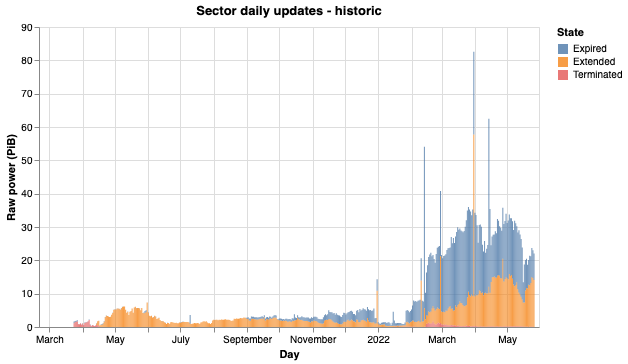

In [4]:
source = (
    df[df["Date"]< pd.Timestamp('2022-05-27T00:00:00.000000+0000')]
    .melt(id_vars=["Date"], value_vars=["Extended", "Expired", "Terminated"])
)

alt.Chart(source).mark_bar(size=1, opacity=0.8).encode(
    x=alt.X('Date:T', title="Day"),
    y=alt.Y('value:Q', title="Raw power (PiB)"),
    color=alt.Color('variable:N', legend=alt.Legend(title="State"))
).properties(
    width=500, height=300, title="Sector daily updates - historic"
)

Looking at the extension and expiration rates over the total sector power expected to expire on any given day, we confirm the observations made before.

In 2021, most sectors were extended, but in 2022 the trend shifted and we observed a majority of sectors expiring instead of extending. This trend is likely due to miners based in China exiting after the crackdown in the summer of 2022. 

After March 2022, we see extension rates recovering somewhat. From a lowest of 20% in March 2022, rates have climbed to 60% after experiencing some volatility.

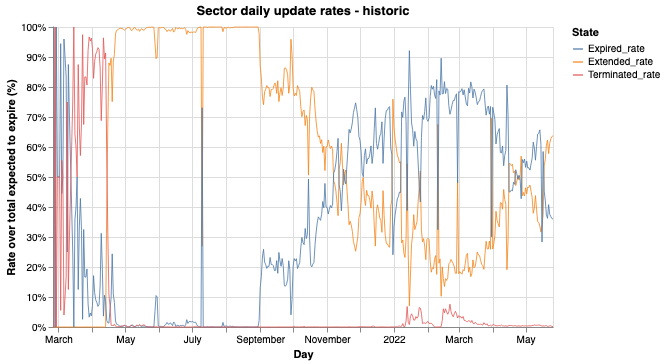

In [5]:
source = (
    df[df["Date"]< pd.Timestamp('2022-05-27T00:00:00.000000+0000')]
    .melt(id_vars=["Date"], value_vars=["Extended_rate", "Expired_rate", "Terminated_rate"])
)

alt.Chart(source).mark_line(size=1, opacity=0.8).encode(
    x=alt.X('Date:T', title="Day"),
    y=alt.Y('value:Q', title="Rate over total expected to expire (%)", axis=alt.Axis(format='%')),
    color=alt.Color('variable:N', legend=alt.Legend(title="State"))
).properties(
    width=500, height=300, title="Sector daily update rates - historic"
)

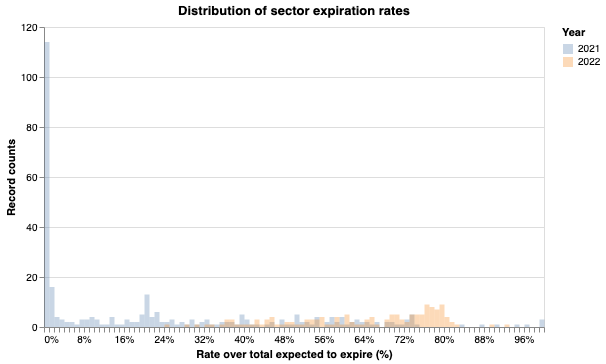

In [6]:
source = df[df["Date"]< pd.Timestamp('2022-05-27T00:00:00.000000+0000')]
source["Interval"] = np.where(source["Date"] < pd.Timestamp('2021-12-31T00:00:00.000000+0000'), "2021", "2022")

alt.Chart(source).mark_bar(
    opacity=0.3,
    binSpacing=0
).encode(
    alt.X('Expired_rate:Q', bin=alt.Bin(maxbins=100), title="Rate over total expected to expire (%)", axis=alt.Axis(format='%')),
    alt.Y('count()', stack=None, title="Record counts"),
    color=alt.Color('Interval:N', legend=alt.Legend(title="Year"))
).properties(
    width=500, height=300, title="Distribution of sector expiration rates"
)

**Overall stats**

In [7]:
temp_df = df[df["Date"]< pd.Timestamp('2022-05-27T00:00:00.000000+0000')]

temp_df[["Extended_rate", "Expired_rate", "Terminated_rate"]].agg(["mean", "median", "std"])

,Extended_rate,Expired_rate,Terminated_rate
mean,0.569668,0.354866,0.074097
median,0.543011,0.358310,0.000807
std,0.346619,0.301761,0.223358


**Stats after April 2022**

In [8]:
temp_df = df[(df["Date"]< pd.Timestamp('2022-05-27T00:00:00.000000+0000')) & (df["Date"]> pd.Timestamp('2022-04-01T00:00:00.000000+0000'))]

temp_df[["Extended_rate", "Expired_rate", "Terminated_rate"]].agg(["mean", "median", "std"])

,Extended_rate,Expired_rate,Terminated_rate
mean,0.451331,0.534353,0.004170
median,0.448692,0.543985,0.003893
std,0.101548,0.105711,0.001382


#### 2.2 Montly sector updates

Looking at monthly aggregates, we get a smoother picture:

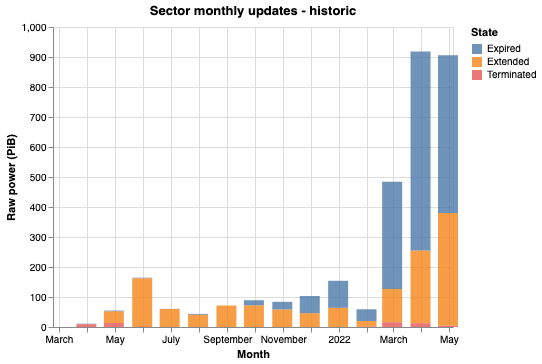

In [9]:
source = (
    month_df[month_df["Date"]< pd.Timestamp('2022-05-27T01:00:00.000000+0000')]
    .melt(id_vars=["Date"], value_vars=["Extended", "Expired", "Terminated"])
)

alt.Chart(source).mark_bar(size=20, opacity=0.8).encode(
    x=alt.X('Date:T', title="Month"),
    y=alt.Y('value:Q', title="Raw power (PiB)"),
    color=alt.Color('variable:N', legend=alt.Legend(title="State"))
).properties(
    width=400, height=300, title="Sector monthly updates - historic"
)

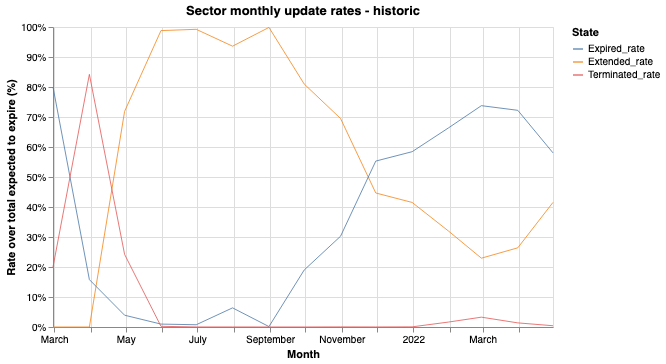

In [10]:
source = (
    month_df[month_df["Date"]< pd.Timestamp('2022-05-27T01:00:00.000000+0000')]
    .melt(id_vars=["Date"], value_vars=["Extended_rate", "Expired_rate", "Terminated_rate"])
)

alt.Chart(source).mark_line(size=1, opacity=0.8).encode(
    x=alt.X('Date:T', title="Month"),
    y=alt.Y('value:Q', title="Rate over total expected to expire (%)", axis=alt.Axis(format='%')),
    color=alt.Color('variable:N', legend=alt.Legend(title="State"))
).properties(
    width=500, height=300, title="Sector monthly update rates - historic"
)

## 3. Future Updates

#### 3.1 Daily sector updates

Looking forward, we can see the power expected to expire in 2022 and 2023, based on the sectors currently active. We can use these known values to forecast network power.

Between June 2022 and April 2023, we see a significant amount of power expected to expire. It is relevant to note three peaks in August, September, and November 2022, which may tip the network power under the Baseline. Something to check in later analysis.

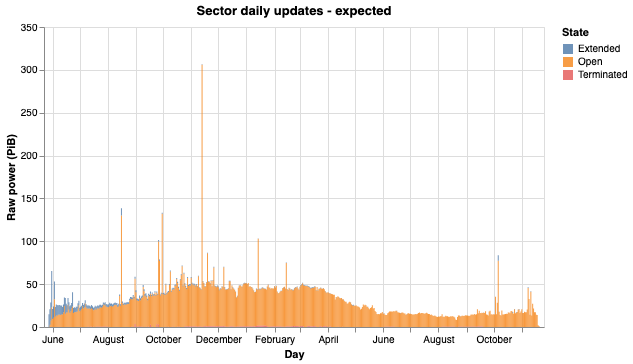

In [11]:
source = (
    df[df["Date"]>=pd.Timestamp('2022-05-27T01:00:00.000000+0000')]
    .melt(id_vars=["Date"], value_vars=["Open", "Extended", "Terminated"])
)

alt.Chart(source).mark_bar(size=1, opacity=0.8).encode(
    x=alt.X('Date:T', title="Day"),
    y=alt.Y('value:Q', title="Raw power (PiB)"),
    color=alt.Color('variable:N', legend=alt.Legend(title="State"))
).properties(
    width=500, height=300, title="Sector daily updates - expected"
)

As expected, the further in the future we go, the more sectors we see still open. The rate of open sectors tails off to almost 100% in December 2022. However, this does not mean that actual expiration rates will decrease from the current 60%/70% as more sectors may start extending as their expiration date comes near.

Here, we see an average termination rate of 0.8%, which may still be a consequence of the China's crackdown and, as such, is already taken into account in the current power stats of the network.

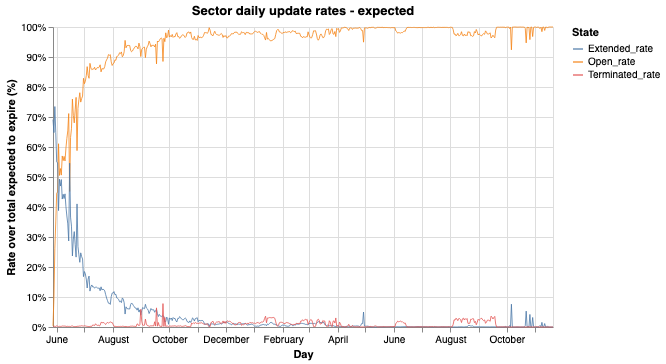

In [12]:
source = (
    df[df["Date"]>=pd.Timestamp('2022-05-27T01:00:00.000000+0000')]
    .melt(id_vars=["Date"], value_vars=["Open_rate", "Extended_rate", "Terminated_rate"])
)

alt.Chart(source).mark_line(size=1, opacity=0.8).encode(
    x=alt.X('Date:T', title="Day"),
    y=alt.Y('value:Q', title="Rate over total expected to expire (%)", axis=alt.Axis(format='%')),
    color=alt.Color('variable:N', legend=alt.Legend(title="State"))
).properties(
    width=500, height=300, title="Sector daily update rates - expected"
)

In [13]:
temp_df = df[df["Date"]>=pd.Timestamp('2022-05-27T01:00:00.000000+0000')]

temp_df[["Open_rate", "Extended_rate", "Terminated_rate"]].agg(["mean", "median", "std"])

,Open_rate,Extended_rate,Terminated_rate
mean,0.946535,0.043958,0.008481
median,0.978645,0.007149,0.003370
std,0.109950,0.103701,0.009943


#### 3.2 Montly sector updates

Once again, looking at monthly aggregates, gives us a smoother picture:

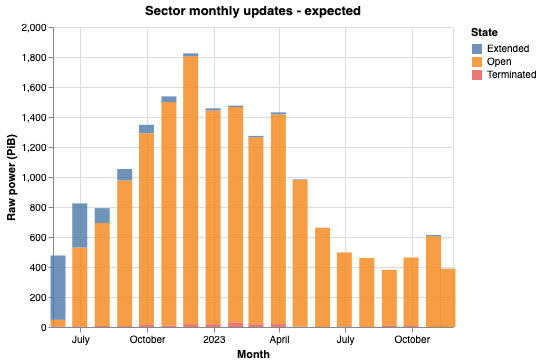

In [14]:
source = (
    month_df[month_df["Date"]>=pd.Timestamp('2022-05-27T01:00:00.000000+0000')]
    .melt(id_vars=["Date"], value_vars=["Open", "Extended", "Terminated"])
)
alt.Chart(source).mark_bar(size=15, opacity=0.8).encode(
    x=alt.X('Date:T', title="Month"),
    y=alt.Y('value:Q', title="Raw power (PiB)"),
    color=alt.Color('variable:N', legend=alt.Legend(title="State"))
).properties(
    width=400, height=300, title="Sector monthly updates - expected"
)

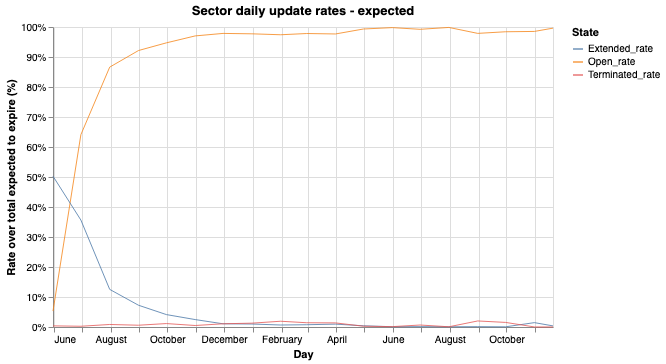

In [15]:
source = (
    month_df[month_df["Date"]>=pd.Timestamp('2022-05-27T01:00:00.000000+0000')]
    .melt(id_vars=["Date"], value_vars=["Open_rate", "Extended_rate", "Terminated_rate"])
)

alt.Chart(source).mark_line(size=1, opacity=0.8).encode(
    x=alt.X('Date:T', title="Day"),
    y=alt.Y('value:Q', title="Rate over total expected to expire (%)", axis=alt.Axis(format='%')),
    color=alt.Color('variable:N', legend=alt.Legend(title="State"))
).properties(
    width=500, height=300, title="Sector daily update rates - expected"
)